In [90]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation

In [101]:
m1 = 1
m2 = 1
m3 = 1
m4 = 1
m5 = 5
m6 = 5
l1 = 1
l2 = 1
l3 = 1
l4 = 1
l5 = 0.1
g = 9.81

dt = 0.01
tf = 20
t = np.arange(0, tf, dt)

Q_0 = np.array([[0, 0], [0, 0], [2.1, -1], [2.1, -1], [1, 0], [1.1, -1]]) #np.array([[0, 0], [0, 0], [1, 1], [1, 1], [1, 0], [0, 1]])
Q_dot_0 = np.array([[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]])

n = 6
k = 4
max_k = 5

M = np.diag([m1, m2, m3, m4, m5, m6]) # n x n
M_inv = np.linalg.inv(M) # n x n
G = np.array([[0, g] for _ in range(n)]) # n x 2
D_of_G = lambda k: np.array([[ 1,  0,  0,  0,  0],
                                [ 0,  1,  0,  0,  0],
                                [ 0,  0,  1,  0,  0],
                                [ 0,  0,  0,  1,  0],
                                [-1, -1,  0,  0,  1],
                                [ 0,  0, -1, -1, -1]])[:n, :k] # n x k

# Edge Control
k1 = 20
k2 = 20

theta_d = lambda t: np.pi/4*np.cos(np.pi/2*t)
theta_d_dot = lambda t: -np.pi**2/8*np.sin(np.pi/2*t)
theta_d_ddot = lambda t: -np.pi**3/16*np.cos(np.pi/2*t)
Qed = lambda t, k: np.array([[l1*np.cos(theta_d(t)), l1*np.sin(theta_d(t))],
                          [-l2*np.cos(theta_d(t)), l2*np.sin(theta_d(t))],
                          [-l3*np.cos(theta_d(t)), -l3*np.sin(theta_d(t))],
                          [l4*np.cos(theta_d(t)), -l4*np.sin(theta_d(t))],
                          [0, l5]])[:k, :]
Qed_dot = lambda t, k: np.array([[-l1*np.sin(theta_d(t))*theta_d_dot(t), l1*np.cos(theta_d(t))*theta_d_dot(t)],
                              [l2*np.sin(theta_d(t))*theta_d_dot(t), l2*np.cos(theta_d(t))*theta_d_dot(t)],
                              [l3*np.sin(theta_d(t))*theta_d_dot(t), -l3*np.cos(theta_d(t))*theta_d_dot(t)],
                              [-l4*np.sin(theta_d(t))*theta_d_dot(t), -l4*np.cos(theta_d(t))*theta_d_dot(t)],
                              [0, 0]])[:k, :]
Qed_ddot = lambda t, k: np.array([[-l1*np.cos(theta_d(t))*theta_d_dot(t)**2-l1*np.sin(theta_d(t))*theta_d_ddot(t), l1*np.sin(theta_d(t))*theta_d_dot(t)**2-l1*np.cos(theta_d(t))*theta_d_ddot(t)], # Unckecked!
                               [l2*np.cos(theta_d(t))*theta_d_dot(t)**2+l2*np.sin(theta_d(t))*theta_d_ddot(t), -l2*np.sin(theta_d(t))*theta_d_dot(t)**2-l2*np.cos(theta_d(t))*theta_d_ddot(t)],
                               [l3*np.cos(theta_d(t))*theta_d_dot(t)**2+l3*np.sin(theta_d(t))*theta_d_ddot(t), -l3*np.sin(theta_d(t))*theta_d_dot(t)**2+l3*np.cos(theta_d(t))*theta_d_ddot(t)],
                               [-l4*np.cos(theta_d(t))*theta_d_dot(t)**2-l4*np.sin(theta_d(t))*theta_d_ddot(t), l4*np.sin(theta_d(t))*theta_d_dot(t)**2+l4*np.cos(theta_d(t))*theta_d_ddot(t)],
                               [0, 0]])[:k, :]

R90 = np.array([[0, -1],
                [1,  0]])

# Node Control
k3 = 20
k4 = 20
# freq = 4
# r5d = lambda t: np.array([0, l5]) if t < 10 else np.array([np.sin(freq*theta_d(t)), 1])
# r5d_dot = lambda t: np.array([0, 0]) if t < 10 else np.array([freq*theta_d_dot(t)*np.cos(freq*theta_d(t)), 0])
# r5d_ddot = lambda t: np.array([0, 0]) if t < 10 else np.array([-(freq*theta_d_dot(t))**2*np.sin(freq*theta_d(t)) + freq*theta_d_ddot(t)*np.cos(freq*theta_d(t))])

def get_desired(t):
    if t < 10:
        r5d = np.array([0, l5])
        r5d_dot = np.array([0, 0])
        r6d = np.array([0, 0])
        r6d_dot = np.array([0, 0])
    else:
        r5d = np.array([0, 1])
        r5d_dot = np.array([0, 0])
        r6d = np.array([0, -1])
        r6d_dot = np.array([0, 0])
    
    return r5d, r5d_dot, r6d, r6d_dot

collided_yet = False

def ODE(t, y):
    global k
    global collided_yet
    
    Q = y[:2*n].reshape((n, 2))
    Q_dot = y[2*n:].reshape((n, 2))
    Qe = D_of_G(k).T@Q
    Qe_dot = D_of_G(k).T@Q_dot

    r1e = Qe[0, :]
    r2e = Qe[1, :]
    r3e = Qe[2, :]
    r4e = Qe[3, :]
    
    temp = np.linalg.inv(np.multiply(D_of_G(k).T@M_inv@D_of_G(k), Qe@Qe.T))
    lambda_simplified = temp @ (Qe_dot@Qe_dot.T).diagonal()
    Lambda_simplified = np.diag(lambda_simplified)

    vec_pd = -k1*(Qe-Qed(t, k)) - k2*(Qe_dot-Qed_dot(t, k)) + Qed_ddot(t, k)
    mat = Qe.T@Lambda_simplified@D_of_G(k).T@M_inv@D_of_G(k)

    u1 = (vec_pd[0, :] + mat[:, 0]).dot(R90@r1e/l1)
    u2 = (vec_pd[1, :] + mat[:, 1]).dot(R90@r2e/l2)
    u3 = (vec_pd[2, :] + mat[:, 2]).dot(R90@r3e/l3)
    u4 = (vec_pd[3, :] + mat[:, 3]).dot(R90@r4e/l4)
    
    r5 = Q[4, :]
    r5_dot = Q_dot[4, :]
    r6 = Q[5, :]
    r6_dot = Q_dot[5, :]

    r5d, r5d_dot, r6d, r6d_dot = get_desired(t)

    F_pd = np.array([m1*u1*R90@r1e/l1,
                     m2*u2*R90@r2e/l2,
                     m3*u3*R90@r3e/l3,
                     m4*u4*R90@r4e/l4,
                     -k3*(r5-r5d) - k4*(r5_dot-r5d_dot),
                     -k3*(r6-r6d) - k4*(r6_dot-r6d_dot)])
    F_g = M@G
    F = F_pd + F_g
    
    lambda_full = temp @ (D_of_G(k).T@M_inv@F@Qe.T + Qe_dot@Qe_dot.T).diagonal()
    Lambda_full = np.diag(lambda_full)
    Q_ddot = -G + M_inv@(F - D_of_G(k)@Lambda_full@Qe)

    # if not collided_yet and np.abs(np.linalg.norm(r5-r6) - l5) < 3e-4:
    #     collided_yet = True
    #     print(f"Collision at time: {t}")
    #     k = 5
    #     return np.zeros(2*n*2)
    
    return np.concatenate((Q_dot.reshape(2*n), Q_ddot.reshape(2*n)))

sol = solve_ivp(ODE, (0, tf), (Q_0[0, 0], Q_0[0, 1], Q_0[1, 0], Q_0[1, 1], Q_0[2, 0], Q_0[2, 1], Q_0[3, 0], Q_0[3, 1], Q_0[4, 0], Q_0[4, 1], Q_0[5, 0], Q_0[5, 1], Q_dot_0[0, 0], Q_dot_0[0, 1], Q_dot_0[1, 0], Q_dot_0[1, 1], Q_dot_0[2, 0], Q_dot_0[2, 1], Q_dot_0[3, 0], Q_dot_0[3, 1], Q_dot_0[4, 0], Q_dot_0[4, 1], Q_dot_0[5, 0], Q_dot_0[5, 1]), t_eval=t, method="DOP853", rtol=1e-10, atol=1e-10)
x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x1_dot, y1_dot, x2_dot, y2_dot, x3_dot, y3_dot, x4_dot, y4_dot, x5_dot, y5_dot, x6_dot, y6_dot = sol.y

k_array = np.array([4 for t in t])

Q = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4], [x5, y5], [x6, y6]])
Qe = np.empty((max_k, 2, len(t)))
for i, ti in enumerate(t):
    Qe[:k_array[i], :, i] = D_of_G(k_array[i]).T@Q[:, :, i]
    Qe[k_array[i]:, :, i] = np.nan

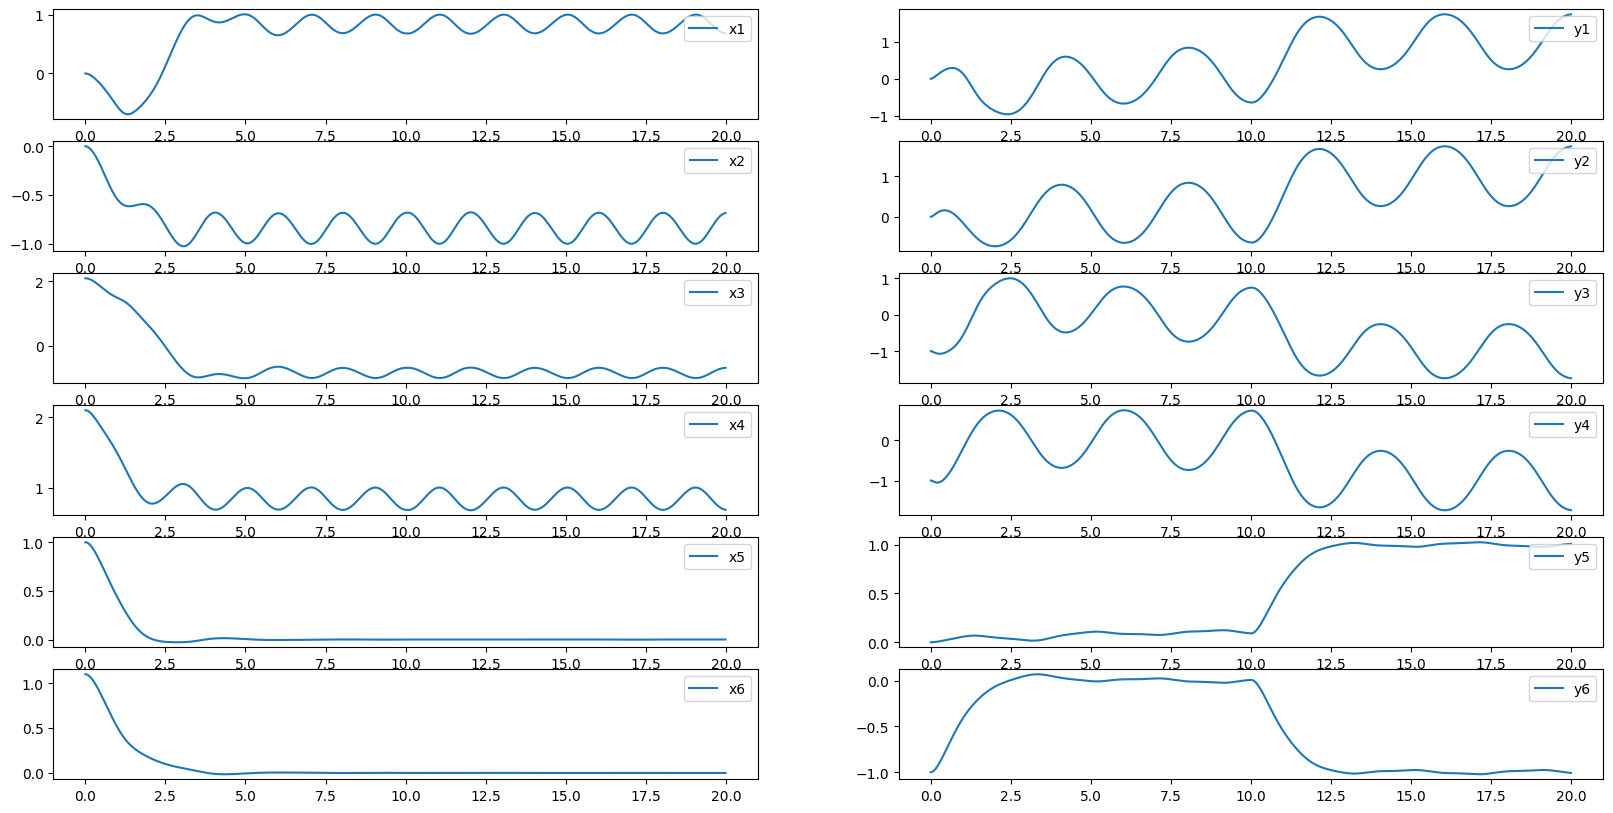

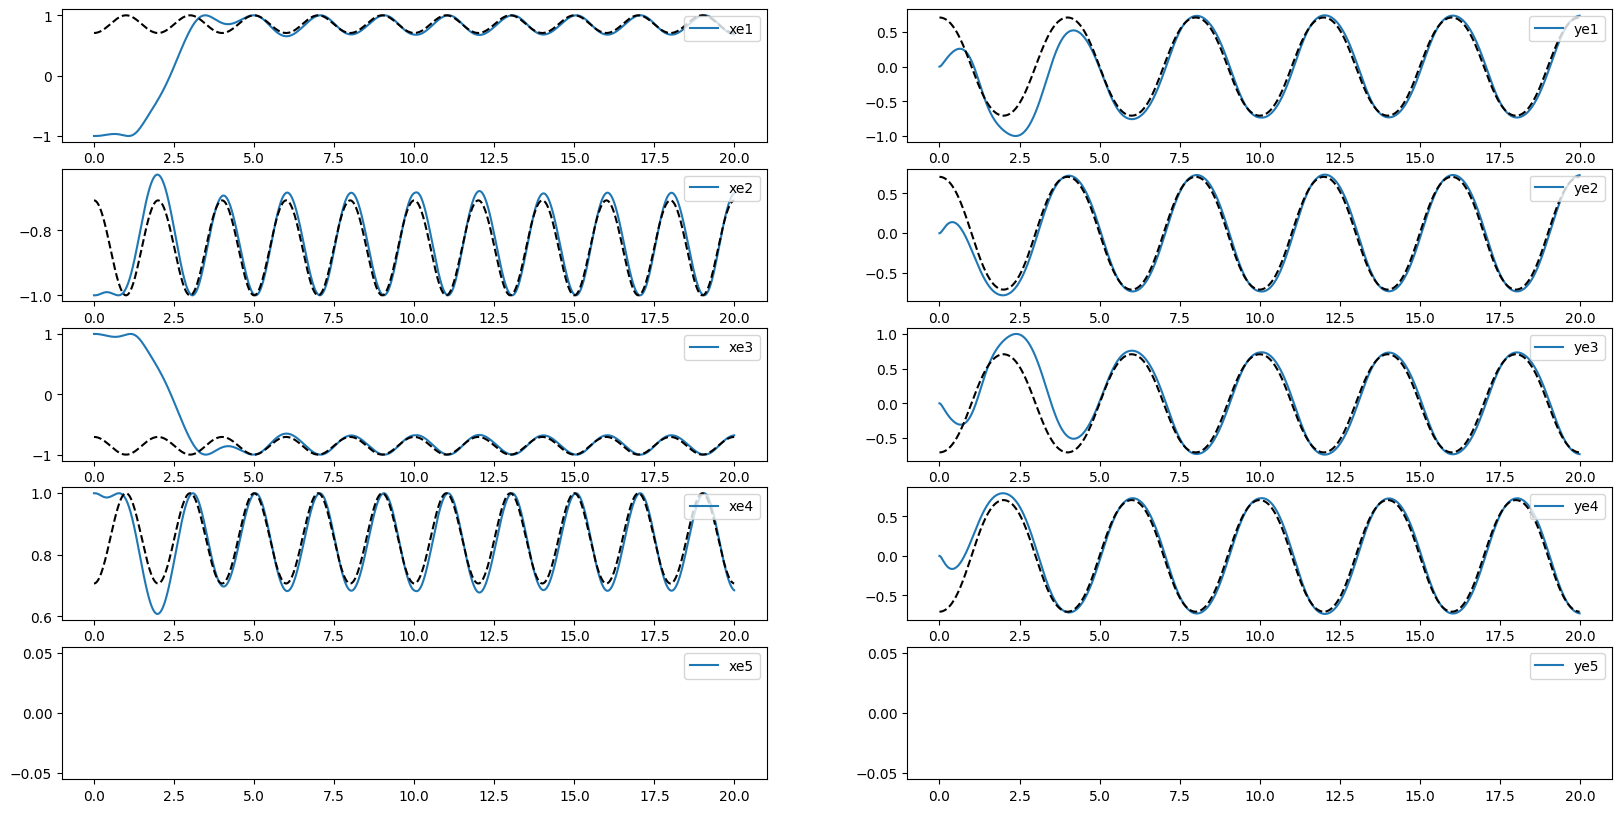

In [102]:
# Nodes
plt.figure(figsize=(20, 10))
for i in range(n):
    plt.subplot(n, 2, 2*i+1)
    plt.plot(t, Q[i, 0], label='x'+str(i+1))
    plt.legend(loc='upper right')
    plt.gca().set_xlim(-0.05*tf, tf + 0.05*tf)

    plt.subplot(n, 2, 2*i+2)
    plt.plot(t, Q[i, 1], label='y'+str(i+1))
    plt.legend(loc='upper right')
    plt.gca().set_xlim(-0.05*tf, tf + 0.05*tf)

# plt.plot(t, np.zeros(len(t)), color='black', linestyle='--')

# Edges
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(5, 2, 2*i+1)
    plt.plot(t, Qe[i, 0, :], label='xe'+str(i+1))
    plt.plot(t, [(Qed(ti, k_array[j])[i, 0] if i < k_array[j] else np.nan) for j, ti in enumerate(t)], color='black', linestyle='--')
    plt.legend(loc='upper right')
    plt.gca().set_xlim(-0.05*tf, tf + 0.05*tf)

    plt.subplot(5, 2, 2*i+2)
    plt.plot(t, Qe[i, 1, :], label='ye'+str(i+1))
    plt.plot(t, [(Qed(ti, k_array[j])[i, 1] if i < k_array[j] else np.nan) for j, ti in enumerate(t)], color='black', linestyle='--')
    plt.legend(loc='upper right')
    plt.gca().set_xlim(-0.05*tf, tf + 0.05*tf)

# # Theta
# plt.figure()
# plt.plot(t, ((q1x-q2x)*(q2x-q3x)+(q1y-q2y)*(q2y-q3y))/(l1*l2), label=r'$\cos\theta$')
# #plt.axhline(Qed_val[0, :].dot(Qed_val[1, :])/(l1*l2), color='black', linestyle='--', label=r'$\cos\theta_{d}$')
# plt.title(r'$\cos\theta$')
# plt.legend()
# #plt.gca().set_ylim(-1.01, -0.99)

# # Forces
# plt.figure()
# plt.plot(t, np.linalg.norm(np.array([f1x, f1y]), axis=0))
# plt.plot(t, np.linalg.norm(np.array([f2x, f2y]), axis=0))
# plt.plot(t, np.linalg.norm(np.array([f3x, f3y]), axis=0))
# plt.title('Forces')
# #plt.legend()
# #plt.gca().set_ylim(-10, 10)

In [95]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2), aspect='equal')
ax.grid()

# Plot initial position
bars = []
for i in range(max_k):
    try:
        d_i = D_of_G(k_array[0])[:, i]
        start_idx = np.where(d_i == 1)[0][0]
        end_idx = np.where(d_i == -1)[0][0]
        bar = ax.plot([Q_0[start_idx, 0], Q_0[end_idx, 0]], [Q_0[start_idx, 1], Q_0[end_idx, 1]], 'o-', lw=2)[0]
        bars.append(bar)
    except:
        bars.append(ax.plot([], [], 'o-', lw=2)[0])

# ax.text(0.05, 0.9, f'time: {t[0]:.1f} s', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5), fontsize=18)

fps = 30
def animate(i):
    idx = int(i/(fps*dt))
    for i in range(k_array[idx]):
        d_i = D_of_G(k_array[idx])[:, i]
        start_idx = np.where(d_i == 1)[0][0]
        end_idx = np.where(d_i == -1)[0][0]
        bars[i].set_data([Q[start_idx, 0, idx], Q[end_idx, 0, idx]], [Q[start_idx, 1, idx], Q[end_idx, 1, idx]])
    if k_array[idx] == 4:
        bars[4].set_data([], [])

tf_sim = tf
ani = animation.FuncAnimation(fig, animate, frames=fps*tf_sim)
ffmpeg_writer = animation.FFMpegWriter(fps=fps)
ani.save(f'X-wing.mp4', writer=ffmpeg_writer)
plt.close(fig)